In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from collections import namedtuple, OrderedDict
torch.cuda.set_device(0)

In [37]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled

(True, 'GeForce GTX 960M', True)

In [2]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [3]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [4]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [5]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [6]:
def bbtohw(a): 
    """Bounding box to Height width.

    Args:
        param1 (arr): [xmin, ymin, xmax, ymax] where (xmin, ymin) 
            and (xmax, ymax) represent the top left and bottom 
            right corners of the bounding box

    Returns:
        arr: [xmin, ymin, width, height]

    """
    return [a[0],a[1],a[2]-a[0],a[3]-a[1]]

assert bbtohw([2, 5, 10, 20]) == [2, 5, 8, 15]

In [7]:
DATA_DIR = "data/road_damage_dataset"

In [8]:
DATA_PATH = Path(DATA_DIR)

In [9]:
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [10]:
examples = pd.read_csv(DATA_PATH/'train_labels.csv')
images = split(examples, 'filename')

In [11]:
print(images[0])

data(filename='Adachi/JPEGImages/train_Adachi_00001.jpg', object=                                      filename  width  height class  xmin  \
9382  Adachi/JPEGImages/train_Adachi_00001.jpg    600     600   D44   424   
9383  Adachi/JPEGImages/train_Adachi_00001.jpg    600     600   D10   114   

      ymin  xmax  ymax  
9382   361   590   546  
9383   432   487   543  )


In [12]:
def print_example(example):
    im = open_image(DATA_PATH/example.filename)
    ax = show_img(im)
    for index, row in example.object.iterrows():
        bb = bbtohw([row['xmin'], row['ymin'], row['xmax'], row['ymax']]) # Bounding box converted to height width
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], row['class'])  

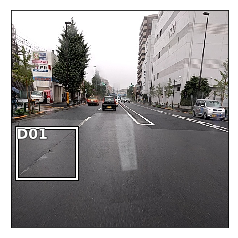

In [28]:
print_example(images[6])

# Multi Class

In [14]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [15]:
mc = [set([row['class'] for index, row in img.object.iterrows()]) for img in images]
mcs = [' '.join(label for label in labels) for labels in mc]
print(mc[0:4])
print(mcs[0:4])

[{'D10', 'D44'}, {'D01'}, {'D01'}, {'D00', 'D01'}]
['D10 D44', 'D01', 'D01', 'D00 D01']


In [16]:
df = pd.DataFrame({'filename': [img.filename for img in images], 'class': mcs}, columns=['filename','class'])
df.to_csv(MULTICLASS_CSV_PATH, index=False)

In [49]:
f_model=resnet34
sz=224
bs=64

In [50]:
tfms = tfms_from_model(f_model, sz)
md = ImageClassifierData.from_csv(DATA_PATH, '', MULTICLASS_CSV_PATH, tfms=tfms, bs=bs)

In [51]:
learn = ConvLearner.pretrained(f_model, md, precompute=True)
learn.opt_fn = optim.Adam

In [52]:
lrf=learn.lr_find(1e-5,100)

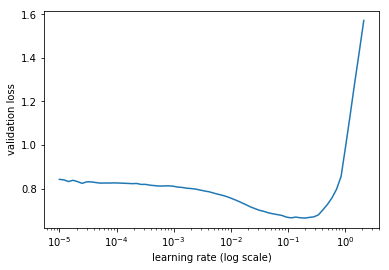

In [53]:
learn.sched.plot(0)

In [54]:
lr = 1e-3

In [55]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                                      
    0      0.631724   0.454852   0.822486  
    1      0.428749   0.367726   0.839069                                      
    2      0.372694   0.363478   0.838445                                      


[array([0.36348]), 0.8384450786293999]

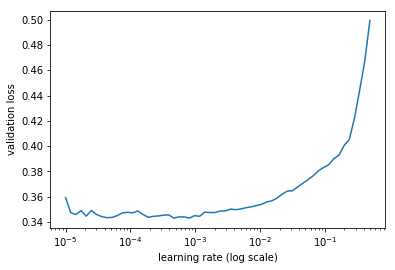

In [59]:
learn.lr_find(1e-5,100)
learn.sched.plot(0)

In [60]:
lr = 1e-5
lrs = np.array([lr/25, lr/5, lr])

In [61]:
learn.freeze_to(-2)

In [62]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,5))

AssertionError: size mismatch, expected 1 lrs, but got 3

In [27]:
learn.sched.plot_lr()

epoch      trn_loss   val_loss   <lambda>                                                                                           
    0      0.31615    0.311619   0.866619  
    1      0.241955   0.299442   0.876605                                                                                           
    2      0.144507   0.323144   0.876337                                                                                           
    3      0.07516    0.336497   0.880171                                                                                           
    4      0.038039   0.339408   0.882489                                                                                           


[array([0.33941]), 0.8824893011686296]

In [28]:
learn.save('mclas')
learn.load('mclas')

In [29]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)

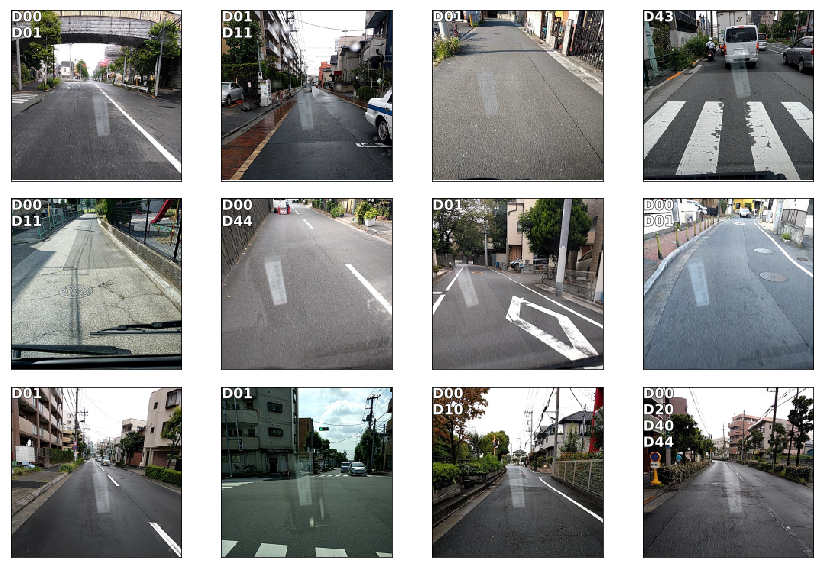

In [30]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i]>0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()